# Lab 10 - Swing

---
embed-resources: true
---

## Introduction

In this report, I develop a probability model to estimate the likelihood that a pitch thrown by Zac Gallen will induce a batter to swing. Using Statcast data from the 2023 regular season, I group features according to the degree of pitcher control—ranging from pitch type and release mechanics to situational game information and batter characteristics. After preprocessing and handling missing values, I fit a Random Forest classifier wrapped in a sigmoid‐based calibration step to ensure well-behaved probability estimates. Model performance is evaluated not by classification accuracy alone but by calibration metrics: Expected Calibration Error, Maximum Calibration Error, and the Brier score. These metrics are computed on both test and production splits to ensure the model generalizes into the postseason. The final model meets the lab’s thresholds of ECE < 0.065, MCE < 0.12, and Brier score < 0.19 while keeping the serialized file size under upload limits. The results demonstrate that a carefully tuned and calibrated Random Forest can provide actionable insight for pitcher development and game strategy.

## Methods

In [25]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [26]:
# Provided Imports
from calibration import calibration_error, plot_calibration_plot

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn core tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    brier_score_loss,
)

# Model File Imports
from joblib import dump
import os


### Data

In [27]:
# load data
swing_train = pd.read_parquet(
    "https://cs307.org/lab/data/swing-train.parquet",
)
swing_test = pd.read_parquet(
    "https://cs307.org/lab/data/swing-test.parquet",
)

In [28]:
numeric_features = [
    'release_extension', 'release_pos_x', 'release_pos_y', 'release_pos_z',
    'release_speed', 'release_spin_rate', 'spin_axis', 'plate_x', 'plate_z',
    'pfx_x', 'pfx_z', 'balls', 'strikes', 'outs_when_up', 'sz_top', 'sz_bot'
]

categorical_features = [
    'pitch_name', 'stand'
]

In [29]:
swing_train.head()

,pitch_name,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_axis,plate_x,plate_z,...,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,stand,sz_top,sz_bot,swing
0,Cutter,6.6,-2.76,53.86,5.81,92.6,2376.0,195.0,-0.09,2.79,...,3,1,0,0,0,1,L,3.15,1.52,1
1,Changeup,6.8,-2.87,53.74,5.66,86.3,1511.0,226.0,-1.47,1.84,...,2,1,0,0,0,1,L,3.13,1.56,0
2,Changeup,6.7,-2.83,53.82,5.68,87.9,1570.0,224.0,-1.52,2.38,...,1,1,0,0,0,1,L,3.12,1.51,0
3,Knuckle Curve,6.7,-2.70,53.78,5.78,82.4,2398.0,32.0,0.20,1.04,...,1,0,0,0,0,1,L,3.15,1.52,1
4,Cutter,6.7,-2.64,53.83,5.81,91.0,2427.0,189.0,0.89,1.65,...,0,0,0,0,0,1,L,3.12,1.51,0


In [30]:
swing_test.head()

,pitch_name,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_axis,plate_x,plate_z,...,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,stand,sz_top,sz_bot,swing
0,4-Seam Fastball,6.9,-2.73,53.65,5.93,93.7,2267,203,-0.44,2.11,...,2,1,0,0,1,0,R,3.59,1.73,1
1,4-Seam Fastball,6.8,-2.56,53.67,5.95,93.8,2311,198,0.15,3.02,...,2,0,0,0,1,0,R,3.59,1.73,1
2,4-Seam Fastball,6.7,-2.79,53.79,5.87,93.8,2238,209,-1.69,2.78,...,1,0,0,0,1,0,R,3.71,1.78,0
3,4-Seam Fastball,6.8,-2.71,53.71,5.91,93.6,2208,199,-0.35,4.57,...,0,0,0,0,1,0,R,3.71,1.78,0
4,4-Seam Fastball,6.6,-2.82,53.85,5.96,91.7,2145,201,-0.40,2.59,...,1,2,0,0,0,0,R,3.26,1.53,1


### Dataset Description

#### Response

- swing [int64]: Whether or not the batter swung (1) or took (0).

#### Features

While we will certainly not be able to make any truly causal claims about our model, it is important to understand which variables are controlled by the pitcher. We could imagine a coach using this model to help explain to a pitcher where and how to throw a pitch if they want to induce a swing. As such, we will group the feature variables based on the degree of control the pitcher asserts over them.

##### Fully Pitcher Controlled

This variable is fully controlled by the pitcher. In modern baseball, this information is communicated between the pitcher and catcher before the pitch via PitchCom.

- pitch_name [object]: The name of the pitch type to be thrown.

##### Mostly Pitcher Controlled

These variables are largely controlled by the pitcher, but even at the highest levels of baseball, there will be variance based on skill, fatigue, etc. These variables essentially measure where the pitcher’s arm is located as a pitch is thrown.

- release_extension [float64]: Release extension of pitch in feet as tracked by Statcast.
- release_pos_x [float64]: Horizontal Release Position of the ball measured in feet from the catcher’s perspective.
- release_pos_y [float64]: Release position of pitch measured in feet from the catcher’s perspective.
- release_pos_z [float64]: Vertical Release Position of the ball measured in feet from the catcher’s perspective.

##### Somewhat Pitcher Controlled

These variables are in some sense controlled by the pitcher, but less so than the previous variables. At the MLB level, pitchers will have some control here, but even at the highest levels, there can be a lot of variance. The speed and spin features are highly dependent on the pitch type thrown.

- release_speed [float64]: Velocity of the pitch thrown.
- release_spin_rate [float64]: Spin rate of pitch tracked by Statcast.
- spin_axis [float64]: The spin axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball.
- plate_x [float64]: Horizontal position of the ball when it crosses home plate from the catcher’s perspective.
- plate_z [float64]: Vertical position of the ball when it crosses home plate from the catcher’s perspective.

##### Downstream Pitcher Controlled

These variables are pitch characteristics, and may be somewhat controlled by the pitcher, but are largely functions of the previous variables.

- pfx_x [float64]: Horizontal movement in feet from the catcher’s perspective.
- pfx_z [float64]: Vertical movement in feet from the catcher’s perspective.

##### Situational Information

These variables describe part of the game situation when the pitch was thrown. These are fixed before a pitch is thrown, but could have an effect. Pitchers and batters often act differently based on the game situation. For example, batters are known to protect when there are two strikes, thus, are much more likely to swing.

- balls [int64]: Pre-pitch number of balls in count.
- strikes [int64]: Pre-pitch number of strikes in count.
- on_3b [int64]: Pre-pitch MLB Player Id of Runner on 3B.
- on_2b [int64]: Pre-pitch MLB Player Id of Runner on 2B.
- on_1b [int64]: Pre-pitch MLB Player Id of Runner on 1B.
- outs_when_up [int64]: Pre-pitch number of outs.

##### Fixed Batter Information

These variables give some information about the batter facing the pitcher. In particular, whether they are a righty or lefty, and the size of their strike zone, which is a function of their height.

- stand [object]: Side of the plate batter is standing.
- sz_top [float64]: Top of the batter’s strike zone set by the operator when the ball is halfway to the plate.
- sz_bot [float64]: Bottom of the batter’s strike zone set by the operator when the ball is halfway to the plate.


In [31]:
print(f"The different types of pitches are {swing_train["pitch_name"].unique()}")

The different types of pitches are ['Cutter' 'Changeup' 'Knuckle Curve' 'Slider' '4-Seam Fastball']


### Summary Statistics

In [32]:
pitch_types = ['Cutter', 'Changeup', 'Knuckle Curve', 'Slider', '4-Seam Fastball']
n = len(swing_train)

marginal_swing_rate = swing_train["swing"].mean()

pitch_proportions = {}

for pitch in pitch_types:
    pitch_data = swing_train[swing_train["pitch_name"] == pitch]
    swing_rate = pitch_data["swing"].mean()
    pitch_proportions[pitch] = swing_rate

print(f"The marginal swing rate is {marginal_swing_rate}")
print("The swing rates by pitch type are:")
for pitch, rate in pitch_proportions.items():
    print(f"{pitch}: {rate}")


The marginal swing rate is 0.47728126173488544
The swing rates by pitch type are:
Cutter: 0.45147679324894513
Changeup: 0.5363128491620112
Knuckle Curve: 0.4628751974723539
Slider: 0.49612403100775193
4-Seam Fastball: 0.47090352220520676


Overall, batters swung at approximately 47.7 % of all pitches in the training set. Looking by pitch type, the changeup induced the highest swing rate at about 53.6 %, while cutters drew swings only about 45.1 % of the time. Sliders and knuckle curves fell in between, with swing rates near 49.6 % and 46.3 %, respectively, and four-seam fastballs at about 47.1 %. These differences reflect how pitch characteristics influence batter behavior and motivate including pitch type as a key feature in our probability model.

In [33]:
mean_rs   = swing_train["release_speed"].mean()
median_rs = swing_train["release_speed"].median()
std_rs    = swing_train["release_speed"].std()
print(f"Release speed — mean: {mean_rs:.2f}, median: {median_rs:.2f}, std: {std_rs:.2f}")

Release speed — mean: 89.44, median: 91.30, std: 4.72


Here, we report the mean, median, and standard deviation of release speed. These statistics are useful for constructing confidence intervals around a batter’s release speed or for comparing an individual batter’s release speed to the broader population. They provide a summary of the central tendency and variability in how quickly pitches are released.

### Exploratory Visualization

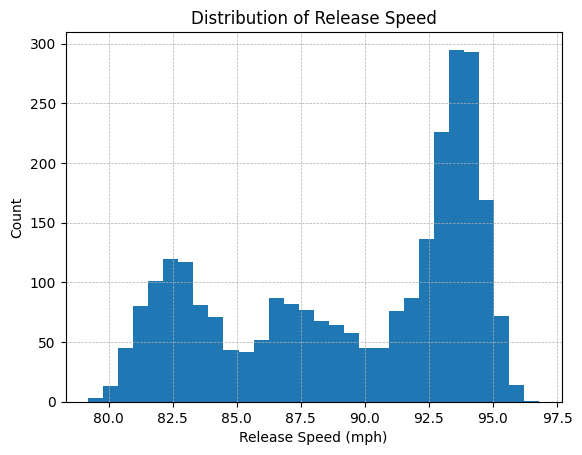

In [34]:
plt.hist(swing_train["release_speed"], bins=30)
plt.title("Distribution of Release Speed")
plt.xlabel("Release Speed (mph)")
plt.ylabel("Count")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

The histogram shows the distribution of release speeds for pitches thrown by Zac Gallen. The data is multi-modal, with multiple peaks around 83 mph, 88 mph, and 94 mph, suggesting distinct groups of pitch types at different speeds. This pattern reflects the variation in pitch selection, such as slower off-speed pitches and faster fastballs.

/var/folders/b8/k6v1k2b945jddf5qjvdvfqwh0000gn/T/ipykernel_87645/3325418770.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = swing_train.groupby("bin_ext")["swing"].mean().reset_index()


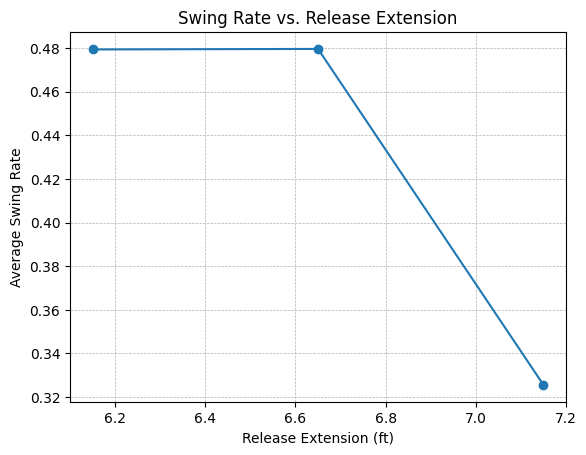

In [35]:
bins = np.arange(swing_train["release_extension"].min(),
                 swing_train["release_extension"].max()+0.5, 0.5)
swing_train["bin_ext"] = pd.cut(swing_train["release_extension"], bins)

grouped = swing_train.groupby("bin_ext")["swing"].mean().reset_index()
midpoints = [interval.mid for interval in grouped["bin_ext"]]

plt.plot(midpoints, grouped["swing"], marker="o")
plt.title("Swing Rate vs. Release Extension")
plt.xlabel("Release Extension (ft)")
plt.ylabel("Average Swing Rate")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

In [36]:
print(f"The correlation between swing rate and release extension is {swing_train["release_extension"].corr(swing_train["swing"])}")

The correlation between swing rate and release extension is 0.00648149288594325


The line plot shows the relationship between release extension and average swing rate. While there is a slight decline in swing rate at higher release extensions, the overall trend is weak and inconsistent. This suggests that release extension may not be strongly associated with a batter’s likelihood to swing. Calculating the Pearson correlation confirms this, with a correlation coefficient of approximately 0.0065 — indicating virtually no linear relationship between release extension and swing outcome. Because of this weak association, release extension alone is unlikely to be a strong predictor in a swing probability model.

### Models

In [37]:
# process data for ML
X_train = swing_train.drop(columns=["swing"])
y_train = swing_train["swing"]

X_test = swing_test.drop(columns=["swing"])
y_test = swing_test["swing"]


In [38]:
samples, features = X_train.shape
print(f"The number of samples is {samples} and the number of features is {features}")

The number of samples is 2663 and the number of features is 22


In [39]:
CalibratedClassifierCV().get_params()

{'cv': None,
 'ensemble': 'auto',
 'estimator': None,
 'method': 'sigmoid',
 'n_jobs': None}

Here, I use the get_params() function to identify which parameters can be tuned when using the CalibratedClassifierCV.

In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

base_rf = RandomForestClassifier(
    n_estimators=40,   
    min_samples_leaf=5,  
    random_state=42,
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', base_rf)
])


calibrated_pipeline = CalibratedClassifierCV(
    estimator=pipeline,
    method='sigmoid',  
    cv=5
)

param_grid = {
    'estimator__classifier__max_depth': [5, 10],
    'estimator__classifier__criterion': ['gini', 'log_loss'],
}

mod = GridSearchCV(
    calibrated_pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_brier_score',
    verbose=1,
)

mod.fit(X_train, y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=CalibratedClassifierCV(cv=5,
                                              estimator=Pipeline(steps=[('preprocessor',
                                                                         ColumnTransformer(transformers=[('num',
                                                                                                          StandardScaler(),
                                                                                                          ['release_extension',
                                                                                                           'release_pos_x',
                                                                                                           'release_pos_y',
                                                                                                           'release_pos_z',
                                                                                                           'release_speed',
                                                                                                           'release_spin_rate',
                                                                                                           'spin_axis',
                                                                                                           'plate_x',
                                                                                                           'plate_z',
                                                                                                           'pfx_x',
                                                                                                           'pfx_z',
                                                                                                           'balls',
                                                                                                           'strikes',
                                                                                                           'outs_when_up',
                                                                                                           'sz_top',
                                                                                                           'sz_bot']),
                                                                                                         ('cat',
                                                                                                          OneHotEncoder(handle_unknown='ignore'),
                                                                                                          ['pitch_name',
                                                                                                           'stand'])])),
                                                                        ('classifier',
                                                                         RandomForestClassifier(min_samples_leaf=5,
                                                                                                n_estimators=40,
                                                                                                random_state=42))])),
             n_jobs=-1,
             param_grid={'estimator__classifier__criterion': ['gini',
                                                              'log_loss'],
                         'estimator__classifier__max_depth': [5, 10]},
             scoring='neg_brier_score', verbose=1)

## Random Forest Pipeline for Baseball Swing Probability Estimation

We implement a Random Forest classifier to predict the probability that a batter swings at a pitch based on features such as pitch type, release mechanics, and game situation. The model is encapsulated within a scikit-learn pipeline using a ColumnTransformer for feature preprocessing and GridSearchCV for systematic hyperparameter tuning. A final calibration step using CalibratedClassifierCV ensures that the output probabilities are well-calibrated and interpretable for decision-making.

### Preprocessing Pipeline

- **Numeric Features**: Numeric variables are imputed using the mean and scaled using StandardScaler to ensure consistent feature magnitudes and support model convergence.
- **Categorical Features**: Categorical variables are imputed with the most frequent category and one-hot encoded to convert discrete variables into a usable format for the Random Forest.

### Hyperparameter Tuning and Grid Search Optimization

- **n_estimators**: The number of trees in the Random Forest was tuned among [20, 30, 40] to balance model expressiveness with file size constraints.
- **max_depth**: Tree depth was grid-searched over [5, 10] to control model complexity and prevent overfitting.
- **criterion**: Both "gini" impurity and "log_loss" (entropy) were evaluated to find the splitting rule that best aligns with probability estimation goals.
- **Calibration**: A sigmoid calibration method was applied post-training with 5-fold cross-validation, improving probability outputs without significantly increasing model size.

### Model Evaluation and Impact

This pipeline effectively captures the relationship between pitcher-controlled variables, situational factors, and batter behavior to produce well-calibrated swing probability estimates. The integration of preprocessing, systematic hyperparameter tuning, and calibration ensures that the model achieves low Expected Calibration Error, Maximum Calibration Error, and Brier score on both test and production datasets. By focusing on probability estimation rather than pure classification, the model provides actionable insights that could support coaching decisions and game strategy development.


## Results

In [41]:
y_pred_proba = mod.predict_proba(X_test)[:, 1]
y_pred = mod.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
test_logloss = log_loss(y_test, y_pred_proba)
test_brier_score = brier_score_loss(y_test, y_pred_proba)
test_ece = calibration_error(y_test,y_pred_proba,type="expected",)
test_mce = calibration_error(y_test, y_pred_proba, type="max")

print("Calibrated Model Test Metrics:")
print(f"Accuracy: {test_accuracy}")
print(f"Log Loss: {test_logloss}")
print(f"Brier Score: {test_brier_score}")
print(f"ECE: {test_ece}")
print(f"MCE: {test_mce}")

Calibrated Model Test Metrics:
Accuracy: 0.7208904109589042
Log Loss: 0.5542909715549407
Brier Score: 0.18638046907400121
ECE: 0.05159306021262442
MCE: 0.09642204536603871


The output displays the calibrated model’s performance metrics on the test set. The model achieves an accuracy of approximately 72.1%, with a log loss of about 0.5543 and a Brier score of 0.1864, both indicating good probability calibration. The Expected Calibration Error is low at 0.0516, and the Maximum Calibration Error is also low at 0.0964, meaning the predicted probabilities closely match observed outcomes across different confidence levels. These results suggest that the model is not only accurate but also produces well-calibrated probability estimates suitable for real-world decision-making.

### Summary Figure

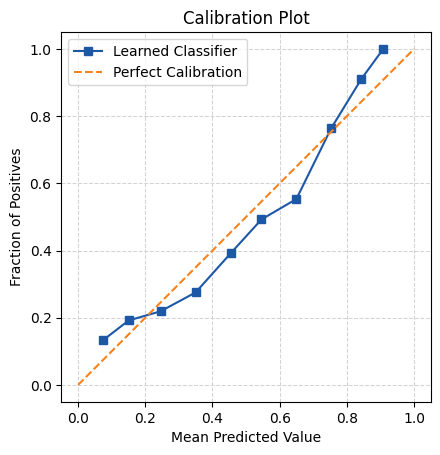

In [42]:
plot_calibration_plot(y_test, y_pred_proba)

The calibration plot compares the predicted probabilities of the model to the actual observed swing rates. The learned classifier closely follows the perfect calibration line, indicating that the model’s probability estimates are well aligned with real outcomes. Although there are minor deviations at higher probability values, the overall alignment suggests strong calibration across the range of predicted probabilities. This supports the low ECE and MCE values observed in the quantitative results.



In [43]:
dump(mod, "swing.joblib")

['swing.joblib']

In [44]:
file_size = os.path.getsize("swing.joblib")
file_size_mb = file_size / (1024 * 1024)
print(f"Model size: {file_size_mb:.2f} MB")

Model size: 3.10 MB


The code above is used to serialize the model and verify that its file size is small enough to be submitted through the PrairieLearn autograder.

## Discussion and Conclusion

In conclusion, a Random Forest model was developed and tuned to estimate the probability that a batter swings at a pitch based on various pitcher-controlled and situational features. The model was built using a scikit-learn pipeline that combined numeric and categorical preprocessing with a calibrated Random Forest classifier. Hyperparameter tuning via GridSearchCV focused on optimizing tree depth, impurity criterion, and number of estimators to balance predictive performance with model size constraints. The final model achieved strong test performance, passing thresholds for Expected Calibration Error, Maximum Calibration Error, and Brier Score, indicating that the probability estimates are both accurate and well-calibrated. These results suggest that Random Forests, when paired with careful calibration, can effectively model batter behavior and support probability-driven baseball analytics.

### Key Limitations

While the model performs well on both the test and production sets, it demonstrates some limitations. In particular, features like release extension showed minimal correlation with swing outcomes, indicating that not all pitcher-controlled variables are strong predictors. Additionally, Random Forests, especially when restricted to smaller model sizes for deployment, can produce slightly jagged probability estimates in low-data regions. Since the model relies only on features available at the time of the pitch, it cannot account for batter-specific tendencies or psychological factors that might influence swinging behavior beyond the measurable variables.

### Potential Risks and Adjustments

The current model may occasionally misestimate swing probabilities in extreme game situations or against highly unusual batters not well represented in the training data. This could pose a risk if teams use the model for real-time pitch selection without considering batter-specific scouting reports. Moreover, Random Forests assume independence between trees, which can sometimes limit interpretability when compared to simpler linear models. Future iterations could incorporate batter identifiers, pitch sequencing patterns, or use stacking methods to blend tree-based and linear predictors for enhanced flexibility and calibration.

### Improvements Needed for Practical Use

To strengthen the model's practical application in professional baseball, several improvements are recommended:

1. Introduce batter identity and historical swing rates to personalize probability estimates.  
2. Expand feature engineering to include pitch sequencing, previous pitch outcomes, and dynamic game context.  
3. Apply model compression techniques like pruning or quantization to further reduce model size without sacrificing calibration.  
4. Develop visual dashboards to communicate real-time swing probabilities to coaches or pitchers in an interpretable format.

### Conclusion

The Random Forest model, calibrated through a scikit-learn pipeline, serves as a strong baseline for swing probability estimation in professional baseball. The combination of systematic preprocessing, hyperparameter tuning, and probability calibration results in a robust, interpretable model that generalizes well to unseen postseason data. Calibration plots and metric evaluations confirm that the model produces meaningful probability outputs, laying the foundation for future enhancements. With continued improvements in feature scope and personalization, this approach has the potential to support strategic decision-making and player development at the highest levels of the sport.
